In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [2]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

simulation_sweep (generic function with 1 method)

In [32]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 350.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.3


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 350.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3


In [33]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


# Multi Agent Support

In [48]:
ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(ip.other_planner.incon, velo_agent_1, velo_agent_2)

In [49]:
@time ibr(ip, 3, "ego", velo_agent_1, velo_agent_2)

  0.061251 seconds (269.36 k allocations: 24.231 MiB, 17.22% gc time)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


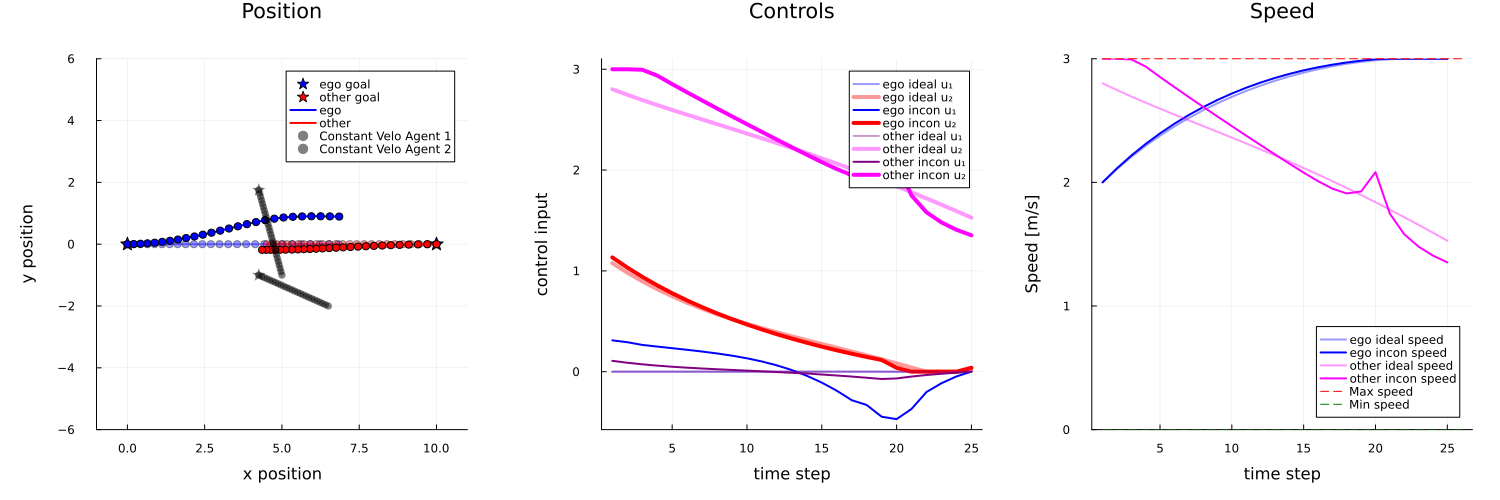

In [50]:
plot_solve_solution(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

┌ Info: Saved animation to /tmp/jl_6J6TO1QpCd.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_6J6TO1QpCd.gif")
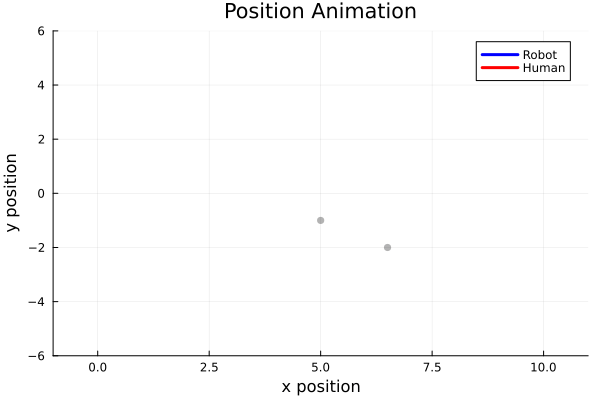

In [51]:
animation(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])